In [ ]:
!pip install opencv-python
!apt-get update
!apt-get install -y libgl1-mesa-glx
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow
!pip install tensorflow-datasets
!pip install transformers
!pip install langchain
!pip install -U langchain-
!pip install faiss-cpu
!pip install sentence-transformers
!pip install tf-keras


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,619 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,738 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,224 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,514 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,51

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the PlantVillage dataset with predefined train and test splits
dataset, info = tfds.load('plant_village', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)

# Unpack the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = dataset

# Define image size and batch size
image_size = (224, 224)
batch_size = 32


In [ ]:
def preprocess_image(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image to [0,1]
    return image, label

# Apply data augmentation to training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

# Preprocessing datasets
train_dataset = train_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Information Visualization
def display_dataset_info(info):
    # Get number of classes and examples
    num_classes = info.features['label'].num_classes
    total_examples = info.splits['train'].num_examples

    print(f"Number of classes: {num_classes}")
    print(f"Total examples: {total_examples}")

print("Displaying dataset information...")
display_dataset_info(info)



Displaying dataset information...
Number of classes: 38
Total examples: 54303



Class Information:
-----------------
Apple___Apple_scab: 501 images
Apple___Black_rot: 467 images
Apple___Cedar_apple_rust: 221 images
Apple___healthy: 1306 images
Blueberry___healthy: 1210 images
Cherry___healthy: 659 images
Cherry___Powdery_mildew: 851 images
Corn___Cercospora_leaf_spot Gray_leaf_spot: 405 images
Corn___Common_rust: 953 images
Corn___healthy: 939 images
Corn___Northern_Leaf_Blight: 788 images
Grape___Black_rot: 956 images
Grape___Esca_(Black_Measles): 1111 images
Grape___healthy: 349 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 881 images
Orange___Haunglongbing_(Citrus_greening): 4399 images
Peach___Bacterial_spot: 1838 images
Peach___healthy: 292 images
Pepper,_bell___Bacterial_spot: 800 images
Pepper,_bell___healthy: 1173 images
Potato___Early_blight: 792 images
Potato___healthy: 122 images
Potato___Late_blight: 801 images
Raspberry___healthy: 302 images
Soybean___healthy: 4043 images
Squash___Powdery_mildew: 1466 images
Strawberry___healthy: 353 images
Stra

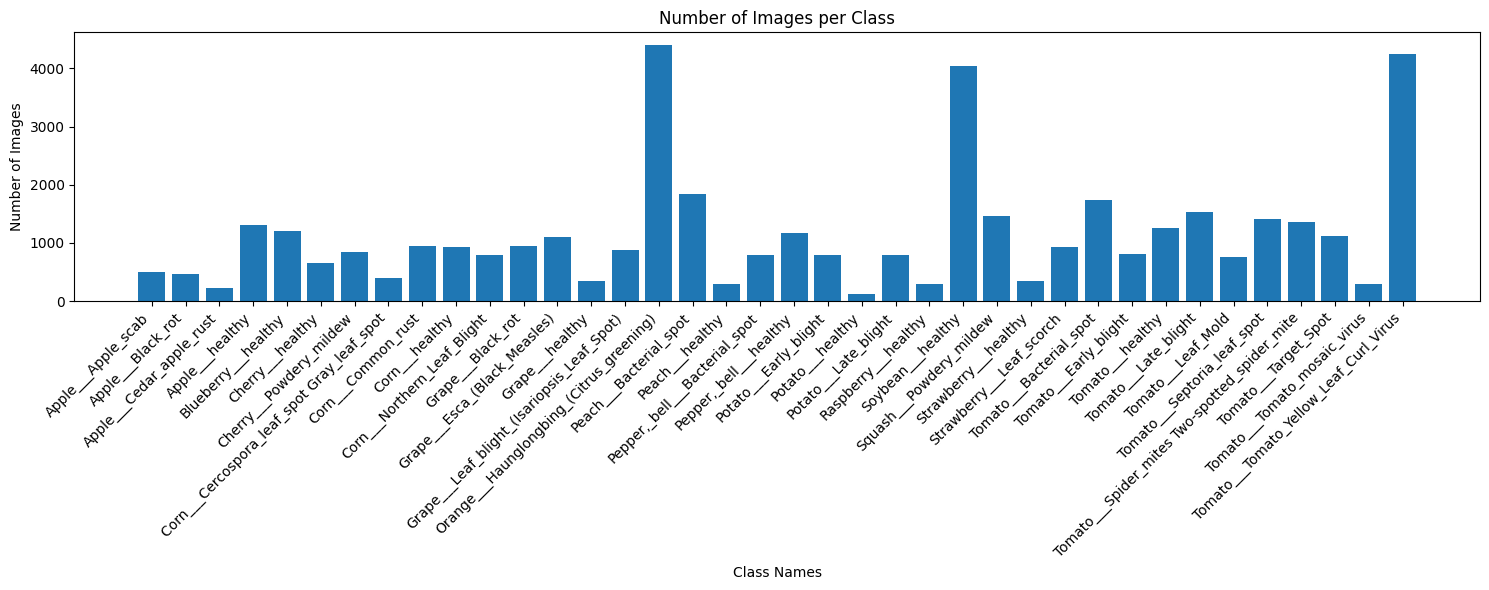

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def analyze_dataset_classes(dataset, info):
    # Get class names
    class_names = info.features['label'].names

    # Create a dictionary to store class counts
    class_counts = {name: 0 for name in class_names}

    # Count instances of each class
    dataset = dataset.unbatch()
    for _, label in dataset:
        class_name = class_names[label.numpy()]
        class_counts[class_name] += 1

    # Print class information
    print("\nClass Information:")
    print("-----------------")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    # Visualize class distribution
    plt.figure(figsize=(15, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Number of Images per Class')
    plt.xlabel('Class Names')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

try:
    analyze_dataset_classes(train_dataset, info)
except Exception as e:
    print(f"An error occurred: {str(e)}")


Showing sample images...


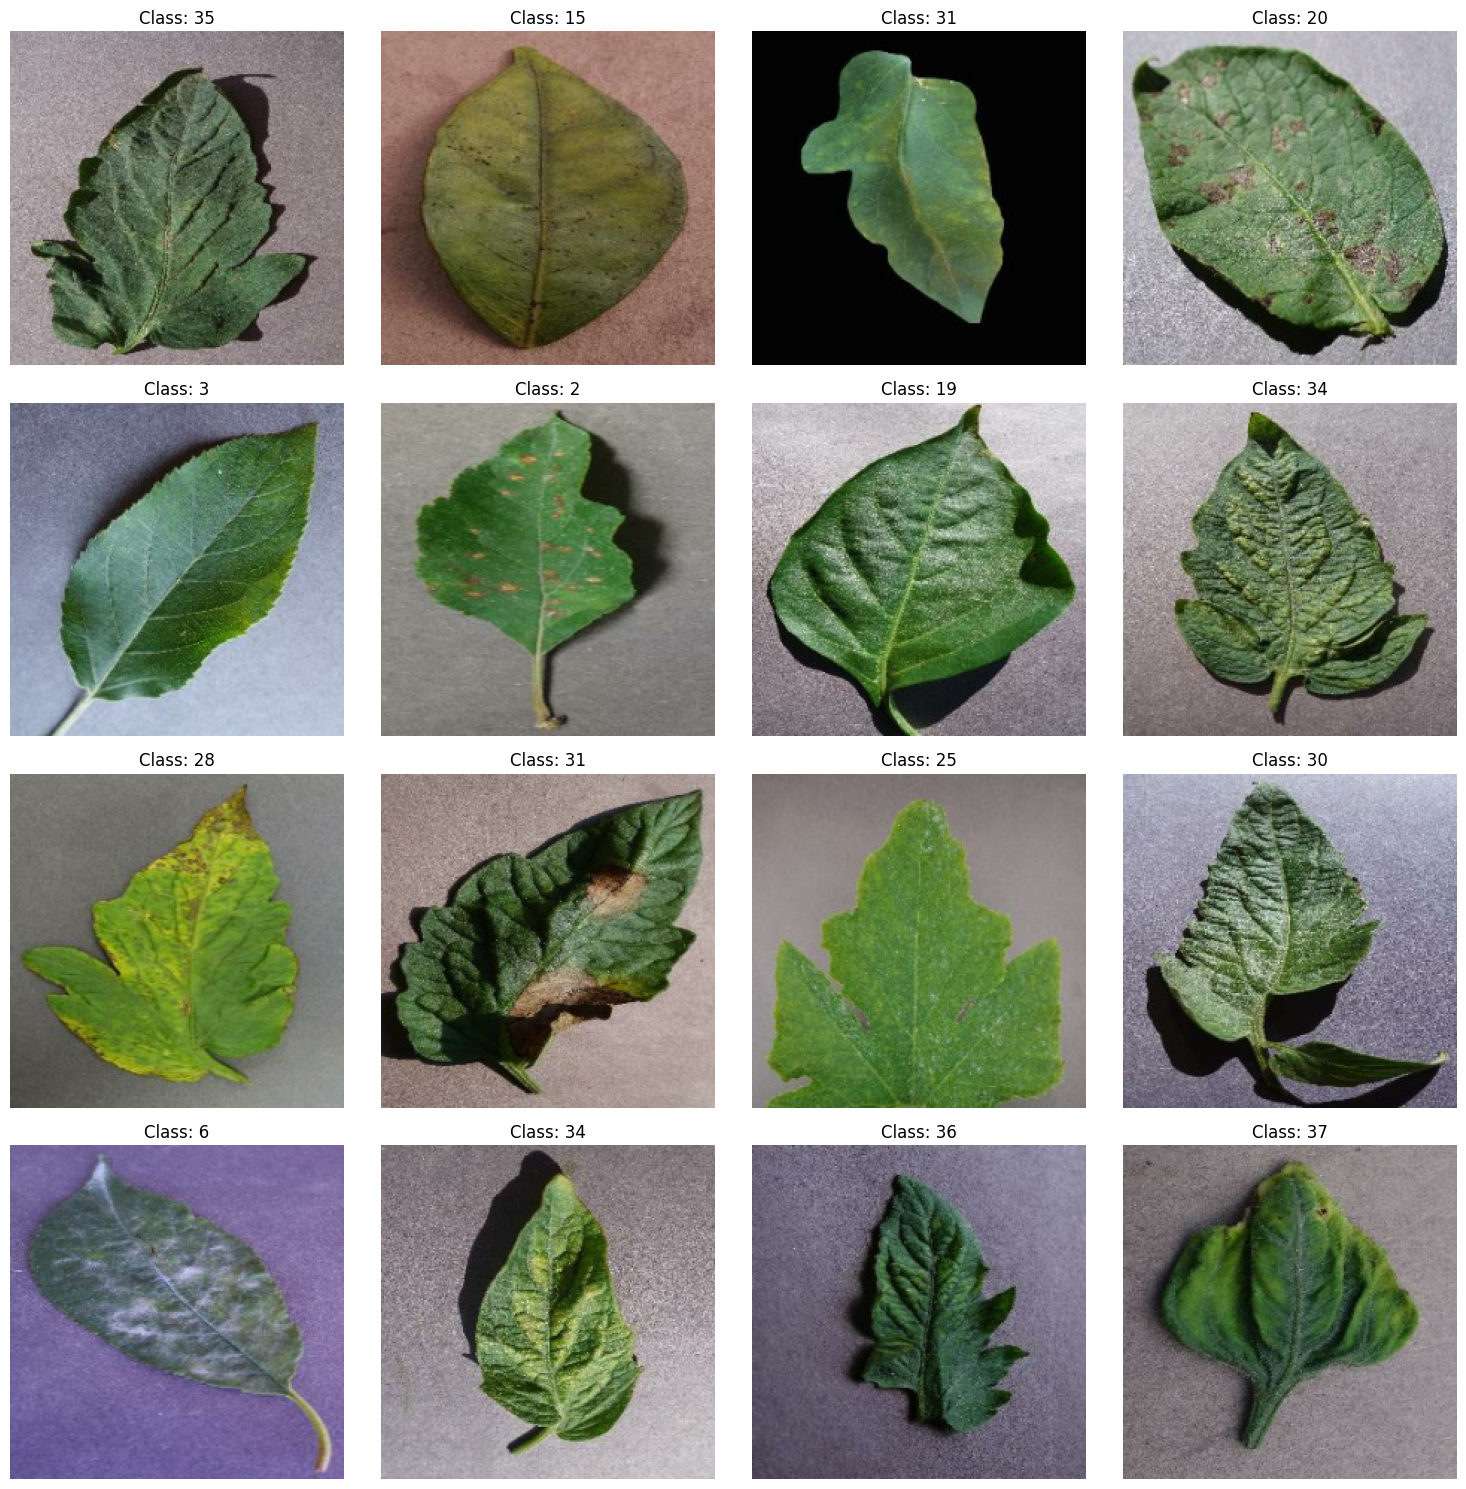

In [ ]:
## Sample Image Visualization
def show_sample_images(dataset, num_samples=16):
    dataset = dataset.unbatch()
    plt.figure(figsize=(15, 15))

    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        plt.title(f'Class: {label.numpy()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nShowing sample images...")
show_sample_images(train_dataset)


Showing augmentation examples...


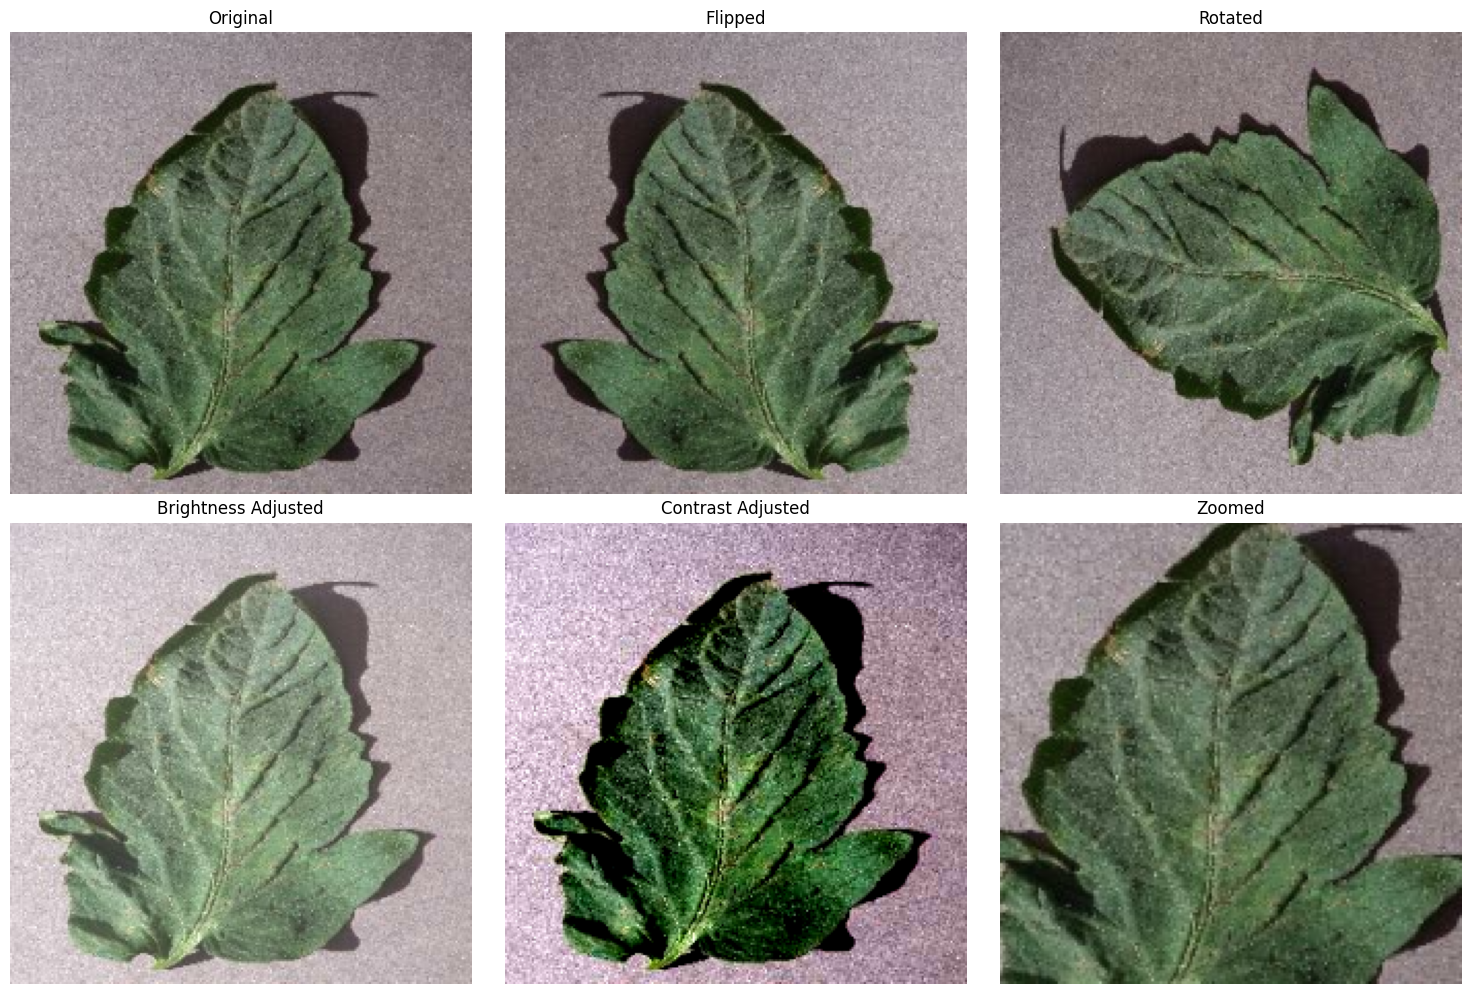

In [ ]:
## Augmentation Preview
def show_augmentation_examples(dataset):
    # Get a single image
    image, label = next(iter(dataset.unbatch().take(1)))

    plt.figure(figsize=(15, 10))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    # Flipped image
    plt.subplot(2, 3, 2)
    plt.imshow(tf.image.flip_left_right(image))
    plt.title('Flipped')
    plt.axis('off')

    # Rotated image
    plt.subplot(2, 3, 3)
    plt.imshow(tf.image.rot90(image))
    plt.title('Rotated')
    plt.axis('off')

    # Brightness adjusted
    plt.subplot(2, 3, 4)
    plt.imshow(tf.image.adjust_brightness(image, 0.2))
    plt.title('Brightness Adjusted')
    plt.axis('off')

    # Contrast adjusted
    plt.subplot(2, 3, 5)
    plt.imshow(tf.image.adjust_contrast(image, 2))
    plt.title('Contrast Adjusted')
    plt.axis('off')

    # Zoomed image
    plt.subplot(2, 3, 6)
    plt.imshow(tf.image.central_crop(image, 0.75))
    plt.title('Zoomed')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nShowing augmentation examples...")
show_augmentation_examples(train_dataset)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model with 4 convolutional layers
model = Sequential([
    # Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # First pooling layer

    # Layer 2
    Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer

    # Layer 3
    Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Third pooling layer

    # Layer 4
    Conv2D(256, (3, 3), activation='relu'),  # Fourth convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Fourth pooling layer

    # Flatten the output for dense layers
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),  # Dense layer with 128 neurons
    Dropout(0.5),  # Dropout for regularization

    # Output layer
    Dense(38, activation='softmax')  # Output layer for 38 classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary (optional)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
# Callbacks
checkpoint_cb = ModelCheckpoint("plant_village_model.keras", save_best_only=True)  # Use .keras extension
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with validation set
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,

)

Epoch 1/20
1358/1358 [==============================] - 588s 432ms/step - loss: 2.0167 - accuracy: 0.4463 - val_loss: 1.0315 - val_accuracy: 0.6862
Epoch 2/20
1358/1358 [==============================] - 573s 422ms/step - loss: 1.0361 - accuracy: 0.6848 - val_loss: 0.5258 - val_accuracy: 0.8409
Epoch 3/20
1358/1358 [==============================] - 571s 420ms/step - loss: 0.7572 - accuracy: 0.7614 - val_loss: 0.3888 - val_accuracy: 0.8757
Epoch 4/20
1358/1358 [==============================] - 568s 419ms/step - loss: 0.5938 - accuracy: 0.8100 - val_loss: 0.3267 - val_accuracy: 0.8962
Epoch 5/20
1358/1358 [==============================] - 568s 418ms/step - loss: 0.4965 - accuracy: 0.8403 - val_loss: 0.2648 - val_accuracy: 0.9138
Epoch 6/20
1358/1358 [==============================] - 568s 419ms/step - loss: 0.4229 - accuracy: 0.8604 - val_loss: 0.2782 - val_accuracy: 0.9149
Epoch 7/20
1358/1358 [==============================] - 567s 418ms/step - loss: 0.3636 - accuracy: 0.8802 - val_

In [ ]:
model.save("Keras_final_model.keras")
model.save("h5_final_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


170/170 [==============================] - 14s 84ms/step - loss: 0.2058 - accuracy: 0.9562
Test Loss: 0.2057742476463318
Test Accuracy: 0.9561694264411926


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model (adjust the filename as per your saved format)
loaded_model = load_model("Keras_final_model.keras")  # Or "best_plant_village_model.keras"
# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


170/170 [==============================] - 16s 91ms/step - loss: 0.2058 - accuracy: 0.9562
Test Loss: 0.2057742476463318
Test Accuracy: 95.62%


1/1 [==============================] - 0s 119ms/step


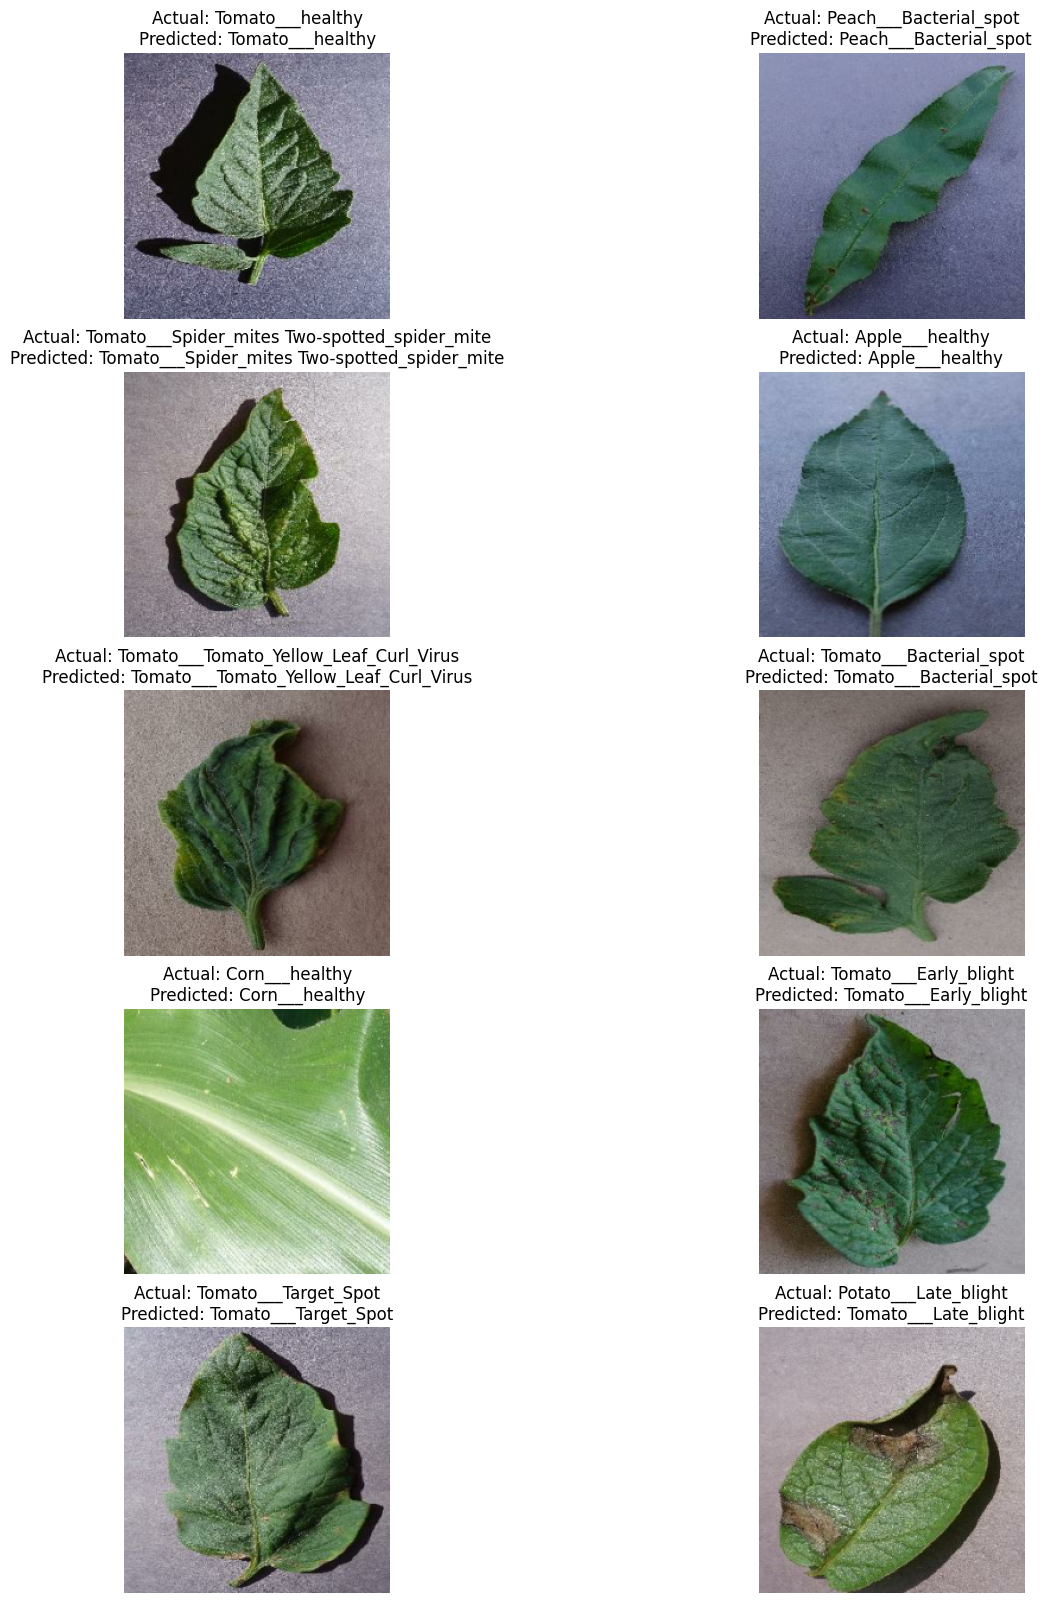

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class names from the dataset info
class_names = info.features['label'].names

# Get a batch of test images and labels
test_batch = next(iter(test_dataset))  # Fetch one batch of test data
images, true_labels = test_batch  # Split the batch into images and labels

# Predict the labels using the trained model
predictions = model.predict(images)  # The batch should have the correct shape
predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the highest prediction probability

# Select random indices
random_indices = np.random.choice(len(images), size=10, replace=False)  # Choose 10 random indices

# Plot the images along with the actual and predicted labels
plt.figure(figsize=(15, 20))
for i, n in enumerate(random_indices):  # Iterate over random indices
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[n].numpy())  # Display the image
    plt.axis('off')

    # Show true and predicted labels
    true_class = class_names[int(true_labels[n])]
    predicted_class = class_names[int(predicted_labels[n])]

    text = f'Actual: {true_class}\nPredicted: {predicted_class}'
    plt.title(text, fontsize=12)

plt.show()


170/170 [==============================] - 14s 83ms/step - loss: 0.2058 - accuracy: 0.9562
Test Loss: 0.2057742476463318
Test Accuracy: 0.9561694264411926
170/170 [==============================] - 15s 90ms/step


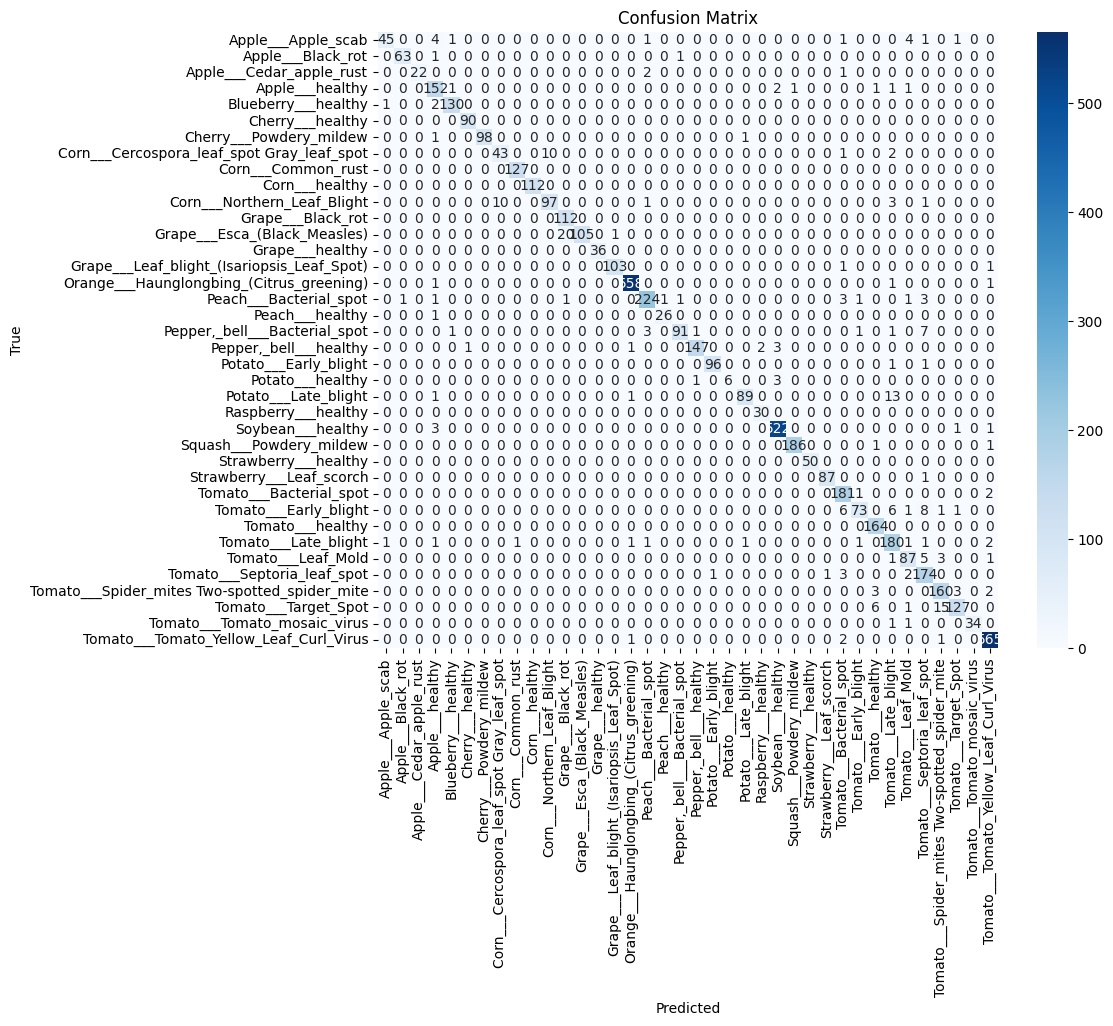

In [ ]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Confusion Matrix and Classification Report
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_report = classification_report(y_true, y_pred_classes, target_names=info.features['label'].names)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=info.features['label'].names, yticklabels=info.features['label'].names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:

# Print classification report
print('Classification Report:')
print(class_report)

Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.96      0.78      0.86        58
                            Apple___Black_rot       0.98      0.97      0.98        65
                     Apple___Cedar_apple_rust       1.00      0.88      0.94        25
                              Apple___healthy       0.90      0.96      0.93       159
                          Blueberry___healthy       0.98      0.98      0.98       133
                             Cherry___healthy       0.99      1.00      0.99        90
                      Cherry___Powdery_mildew       1.00      0.98      0.99       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.77      0.79        56
                           Corn___Common_rust       0.99      1.00      1.00       127
                               Corn___healthy       1.00      1.00      1.00       112
                  C

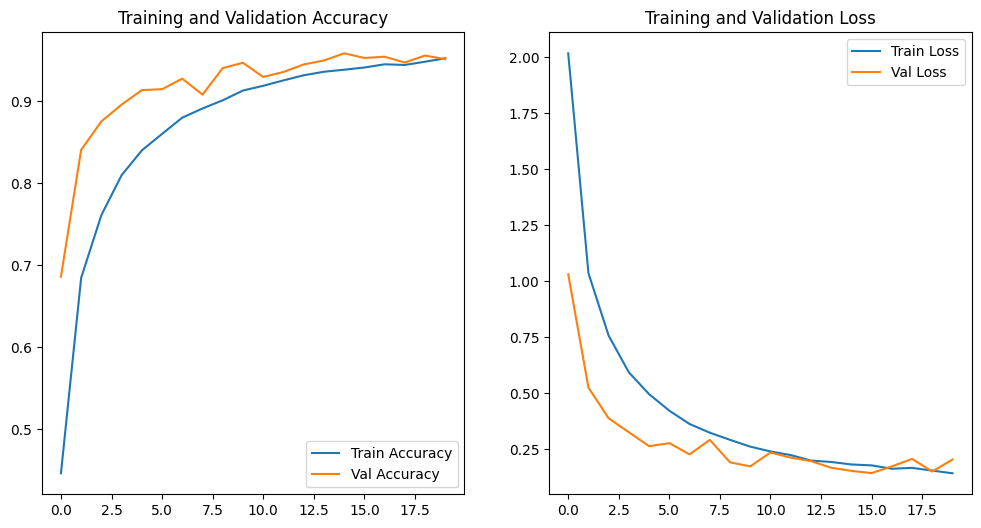

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2
import numpy as np

# Load the saved model
model = load_model("Keras_final_model.keras")

# Define the image size expected by the model
image_size = (224, 224)

def preprocess_image2(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")

    # Resize and normalize the image
    image = cv2.resize(image, image_size)
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # Normalize image to [0,1]
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Path to the input image
input_image_path = "p_t.jpeg"

# Preprocess the input image
input_image = preprocess_image2(input_image_path)

# Make a prediction
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)

# Get the class names from the dataset info
class_names = info.features['label'].names
predicted_label = class_names[predicted_class[0]]

print(f"Predicted Label: {predicted_label}")


1/1 [==============================] - 0s 92ms/step
Predicted Label: Tomato___Septoria_leaf_spot


## **LLM CODING**

In [ ]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4


In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 37.6 MB/s eta 0:00:00


In [ ]:
!pip install -U langchain-community
!pip install faiss-cpu


In [ ]:
!pip install openai==0.28

In [ ]:
!pip install -U langchain-community
!pip install faiss-cpu
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
!pip install tiktoken

In [ ]:
from transformers import LlamaTokenizer, LlamaForCausalLM
import torch

model_name = "meta-llama/Llama-2-7b-hf"

# Step 2: Load the tokenizer and model
tokenizer = LlamaTokenizer.from_pretrained(model_name)
model = LlamaForCausalLM.from_pretrained(model_name)

# Step 3: Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Step 4: Define the input prompt
prompt = "How to cure banana leaf disease?"

# Tokenize the input
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Step 5: Generate a response
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=128,  # Adjust the max output length
        temperature=0.7,     # Control creativity (higher = more diverse outputs)
        top_p=0.9,           # Use nucleus sampling
        top_k=50,            # Limit to top-k tokens for sampling
        do_sample=True       # Enable sampling
    )

# Step 6: Decode and print the response
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

How to cure banana leaf disease?
What is the treatment for banana leaf disease?
How do you get rid of banana leaf disease?
What is the cause of banana leaf disease?
What is the treatment of banana leaf spot disease?
What is the best fungicide for banana leaf spot?
What are the signs of banana leaf spot?
What is the treatment for banana leaf spot?
How do you know if your banana has a fungus?
What is banana leaf disease?
How do you treat fungus on bananas?
What does fungus look like on bananas?
How


In [ ]:
prompt = "You are an expert in plant diseases. Explain how to cure banana leaf disease in detail."
inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.5,
        top_p=0.9,
        do_sample=False
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


You are an expert in plant diseases. Explain how to cure banana leaf disease in detail.
Banana leaf disease is caused by a fungus called Fusarium oxysporum f. sp. cubense. This fungus attacks the roots of the banana plant, causing the plant to wilt and die. The disease is most common in tropical and subtropical regions, where the climate is warm and humid.
There are several ways to cure banana leaf disease. One is to remove and destroy any infected leaves. Another is to apply a fungicide to the plant. Finally, you can also try to improve the drainage around the plant to prevent the fungus from spreading.
How to cure banana leaf disease?
Banana leaf disease is a fungal disease that affects banana plants. The disease is caused by the fungus Fusarium oxysporum f. sp. cubense. The disease is most common in tropical and subtropical regions, where the climate is warm and humid.
The disease is most common in tropical and subtropical regions, where the climate is warm and humid. The disease is

In [ ]:
# Decode the output
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Split the response into lines (based on punctuation or new lines)
lines = response.split("\n")  # You can also use `.split(". ")` for sentence-level splitting

# Print each line neatly
for i, line in enumerate(lines, start=0):
    print(f"{i}. {line.strip()}")


0. You are an expert in plant diseases. Explain how to cure banana leaf disease in detail.
1. Banana leaf disease is caused by a fungus called Fusarium oxysporum f. sp. cubense. This fungus attacks the roots of the banana plant, causing the plant to wilt and die. The disease is most common in tropical and subtropical regions, where the climate is warm and humid.
2. There are several ways to cure banana leaf disease. One is to remove and destroy any infected leaves. Another is to apply a fungicide to the plant. Finally, you can also try to improve the drainage around the plant to prevent the fungus from spreading.
3. How to cure banana leaf disease?
4. Banana leaf disease is a fungal disease that affects banana plants. The disease is caused by the fungus Fusarium oxysporum f. sp. cubense. The disease is most common in tropical and subtropical regions, where the climate is warm and humid.
5. The disease is most common in tropical and subtropical regions, where the climate is warm and hum

In [ ]:
!pip install openai==0.28

In [ ]:
import openai

# Set your OpenAI API key
openai.api_key = "YOUR_OPENAI_API_KEY"  # Replace with your actual API key

# Define the prompt
prompt = "You are an expert in plant diseases. Explain how to cure banana leaf disease in detail."

# Call GPT-4
response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a helpful assistant and an expert in plant diseases."},
        {"role": "user", "content": prompt}
    ],
    max_tokens=300,         # Adjust the output length
    temperature=0.5,        # Control creativity
    top_p=0.9,              # Nucleus sampling
    frequency_penalty=0,    # Reduce repetition
    presence_penalty=0      # Encourage new topics
)

# Extract and print the response
print("GPT-4 Response:\n")
print(response['choices'][0]['message']['content'])


GPT-4 Response:

Banana leaf disease, often caused by fungi such as Black Sigatoka or Panama disease, can be challenging to manage but not impossible. Here's a detailed guide on how to cure banana leaf disease:

1. Identify the Disease: The first step is to identify the type of disease affecting your banana plants. Black Sigatoka, for instance, causes dark streaks on the leaves, while Panama disease can cause wilting and yellowing of leaves. 

2. Prune Infected Leaves: Once identified, prune the infected leaves using a sanitized cutter to prevent the spread of the disease. Be careful not to cut too much, as this can stress the plant. 

3. Fungicide Application: For fungal diseases like Black Sigatoka, fungicides are the most effective treatment. Use a fungicide that contains active ingredients like mancozeb, chlorothalonil, or propiconazole. Follow the manufacturer's instructions on the label for the proper dilution rate and application method. 

4. Regular Monitoring: After the initia

In [ ]:
# Print the response line by line
response_text = response['choices'][0]['message']['content']
lines = response_text.split("\n")
for i, line in enumerate(lines, start=1):
    print(f"{i}. {line.strip()}")


1. Banana leaf disease, often caused by fungi such as Black Sigatoka or Panama disease, can be challenging to manage but not impossible. Here's a detailed guide on how to cure banana leaf disease:
2. 
3. 1. Identify the Disease: The first step is to identify the type of disease affecting your banana plants. Black Sigatoka, for instance, causes dark streaks on the leaves, while Panama disease can cause wilting and yellowing of leaves.
4. 
5. 2. Prune Infected Leaves: Once identified, prune the infected leaves using a sanitized cutter to prevent the spread of the disease. Be careful not to cut too much, as this can stress the plant.
6. 
7. 3. Fungicide Application: For fungal diseases like Black Sigatoka, fungicides are the most effective treatment. Use a fungicide that contains active ingredients like mancozeb, chlorothalonil, or propiconazole. Follow the manufacturer's instructions on the label for the proper dilution rate and application method.
8. 
9. 4. Regular Monitoring: After the

In [ ]:
import faiss
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import openai
from sentence_transformers import SentenceTransformer

# Load the Keras model
model = load_model('plant_village_model.keras')

# Load the LLM data
with open('llm_data.txt', 'r') as file:
    llm_data = file.readlines()

# Convert llm_data to embeddings using a pre-trained model (e.g., SentenceTransformer)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create embeddings for each line in the llm_data
embeddings = embedding_model.encode(llm_data)

# Create a FAISS index
embedding_dim = embeddings.shape[1]  # Dimension of the embeddings
index = faiss.IndexFlatL2(embedding_dim)  # L2 is commonly used for similarity search
index.add(embeddings)

# List of class names
class_names = [
    "Orange___Haunglongbing_(Citrus_greening)",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Soybean___healthy",
    "Peach___Bacterial_spot",
    "Tomato___Bacterial_spot",
    "Tomato___Late_blight",
    "Squash___Powdery_mildew",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Apple___healthy",
    "Tomato___healthy",
    "Blueberry___healthy",
    "Pepper,_bell___healthy",
    "Tomato___Target_Spot",
    "Grape___Esca_(Black_Measles)",
    "Corn___Common_rust",
    "Grape___Black_rot",
    "Corn___healthy",
    "Strawberry___Leaf_scorch",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Cherry___Powdery_mildew",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Tomato___Early_blight",
    "Pepper,_bell___Bacterial_spot",
    "Corn___Northern_Leaf_Blight",
    "Tomato___Leaf_Mold",
    "Cherry___healthy",
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Corn___Cercospora_leaf_spot Gray_leaf_spot",
    "Strawberry___healthy",
    "Grape___healthy",
    "Tomato___Tomato_mosaic_virus",
    "Raspberry___healthy",
    "Peach___healthy",
    "Apple___Cedar_apple_rust",
    "Potato___healthy"
]

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))  # Resize to model input size if needed
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Classify the disease
def classify_image(model, image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    return class_index, class_names[class_index]

# Set up OpenAI API key
openai.api_key = 'YOUR_OPENAI_API_KEY'

# Function to query the FAISS index and LLM
def query_llm(prompt, disease_name):
    # Encode the prompt for similarity search
    query_embedding = embedding_model.encode([prompt])

    # Search the FAISS index for the top 5 most relevant snippets
    _, indices = index.search(query_embedding, 5)
    relevant_texts = [llm_data[i] for i in indices[0]]

    # Combine relevant texts as context for the LLM
    context = "\n".join(relevant_texts)

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": f"You are an expert in {disease_name} and can answer questions based on your knowledge and additional provided data."},
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": context}
        ]
    )
    return response['choices'][0]['message']['content']

# Main function
def main():
    image_path = input("Enter the path of the image file: ")
    class_index, disease_name = classify_image(model, image_path)
    print(f"The classified disease is: {disease_name} (Index: {class_index})")

    # Run a loop to keep answering queries related to the identified disease
    while True:
        query = input(f"Ask about {disease_name}, precautions, or additional information (type 'exit' to quit): ")
        if query.lower() == 'exit':
            break
        response = query_llm(query, disease_name)
        print("LLM Response:")
        print(response)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Enter the path of the image file: p_t.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The classified disease is: Strawberry___Leaf_scorch (Index: 18)
Ask about Strawberry___Leaf_scorch, precautions, or additional information (type 'exit' to quit): cure
LLM Response:
Strawberry leaf scorch, caused by the Diplocarpon earliana fungus, doesn't have a known cure once the plant is infected. You can manage the disease better by adopting the following strategies:

- Fungicides: Use a fungicide suitable for leaf scorch to control the spread of the disease. 
- Rotation: If possible, practice crop rotation with non-host plants to break the disease cycle.
- Resistant varieties: Plant resistant strawberry varieties, if available. 
- Sanitation: Keep the garden or field free from fallen leaves and debris. Good hygiene can prevent disease spores from spreading.
- Watering: Water at the base of the plants rather than overhead to keep the leaves dry. Fungal spores thrive in wet conditions.
- Pruning: Remove a